In [1]:
import os
# path_dir1 = '../home/augmentation/train/'
path_dir2 = '../home/augmentation/test/'
path_dir1 = '../home/CARD/train/'

sub_directory = ['true/','false/']

TRAIN_NUM = 0
TEST_NUM = 0

for subdir in sub_directory:
    tmp_list = os.listdir(path_dir1+subdir)
    TRAIN_NUM += len(tmp_list)
    
for subdir in sub_directory:
    tmp2_list = os.listdir(path_dir2+subdir)
    TEST_NUM += len(tmp2_list)
    

In [2]:
print(TRAIN_NUM)
print(TEST_NUM)

41
27


In [3]:
import numpy as np

train_img = np.float32(np.zeros((TRAIN_NUM,224,224,3)))
train_label = np.uint8(np.zeros((TRAIN_NUM,)))

test_img = np.float32(np.zeros((TEST_NUM,224,224,3)))
test_label = np.uint8(np.zeros((TEST_NUM,)))

In [7]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input

make_label = [0,1]

num = 0
idx = 0
for subdir in sub_directory:
    give_label = make_label[idx]
    for file in os.listdir(path_dir1+subdir):
        if subdir == '.ipynb_checkpoints':
            continue
        if file == '.ipynb_checkpoints':
            continue
        src_path = path_dir1 + subdir + file
        img = load_img(src_path, target_size = (224,224))

        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)
        
        train_img[num, :, :, :] = x

        train_label[num] = give_label
        num = num + 1
    idx += 1

In [8]:
num = 0
idx = 0

for subdir in sub_directory:
    give_label = make_label[idx]
    for file in os.listdir(path_dir2+subdir):
        src_path = path_dir2 + subdir + file
        img = load_img(src_path, target_size = (224,224))

        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)
        
        test_img[num, :, :, :] = x

        test_label[num] = give_label
        num = num + 1
    idx += 1

In [9]:
import keras

train_label = keras.utils.to_categorical(train_label,2)
test_label = keras.utils.to_categorical(test_label,2)

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# create a data generator

# #saved to directory
# inputDir = '../home/CARD/train/'
# outputDir = '../home/CARD/test/'

datagen = ImageDataGenerator(
        brightness_range = [0.7,1.3], 
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range = 0.1,
        rotation_range=45, 
        horizontal_flip=True,  
        vertical_flip=False)


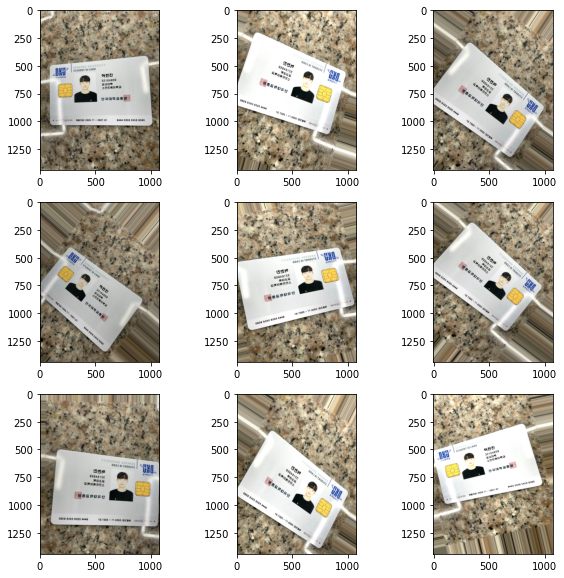

In [11]:
import matplotlib.pyplot as plt

img = load_img('../home/STUDENT_CARD_SAMPLE/1.jpg')
data = img_to_array(img)
samples = np.expand_dims(data, 0)

datagen.fit(train_img)
datagen.fit(test_img)


it = datagen.flow(samples, batch_size=32)

fig = plt.figure(figsize = (10,10))

plt.subplot(3,3,1)
plt.imshow(img)

# 9개 이미지 생성
for i in range(8):
    plt.subplot(3, 3, i+2)
    batch = it.next()
    image = batch[0].astype('uint8')
    plt.imshow(image)

# show the figure
plt.show()

In [12]:
from keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,AveragePooling2D,Flatten,Dropout,GlobalAveragePooling2D,BatchNormalization, LeakyReLU
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

save = '../home/augmentation/train'

In [13]:
with tf.device('/gpu:0'):
    base_model = keras.applications.ResNet152(
        include_top=False,
        weights="imagenet",
        input_shape=(224,224,3)
    )
    base_model.trainable = False
    x = keras.layers.GlobalAveragePooling2D()(base_model.output)
    x = keras.layers.Dense(128,activation= 'relu')(x)
    x = keras.layers.Dropout(0.5)(x)
    predictions = keras.layers.Dense(2,activation = 'sigmoid')(x)
    

    model = keras.models.Model(inputs = base_model.input,outputs =predictions)

    model.compile(optimizer = keras.optimizers.Adam(lr = 0.00001),
                  loss = 'binary_crossentropy',
                  metrics = ['accuracy',])
    
    history = model.fit(datagen.flow(train_img,train_label,batch_size=32),#save_to_dir='../home/augmentation'),
                        validation_data=datagen.flow(test_img,test_label,batch_size =32),
                        batch_size = 8,
                        epochs=30)

    model.save("model.h5")

Epoch 1/30
2/2 [==============================] - 16s 7s/step - loss: 0.8893 - accuracy: 0.4318 - val_loss: 0.6804 - val_accuracy: 0.7778
Epoch 2/30
2/2 [==============================] - 5s 3s/step - loss: 0.8523 - accuracy: 0.6103 - val_loss: 0.6936 - val_accuracy: 0.7037
Epoch 3/30
2/2 [==============================] - 5s 4s/step - loss: 0.9642 - accuracy: 0.5014 - val_loss: 0.6644 - val_accuracy: 0.8148
Epoch 4/30
2/2 [==============================] - 5s 3s/step - loss: 0.7722 - accuracy: 0.5394 - val_loss: 0.6236 - val_accuracy: 0.7778
Epoch 5/30
2/2 [==============================] - 5s 4s/step - loss: 0.8328 - accuracy: 0.5962 - val_loss: 0.5905 - val_accuracy: 0.8519
Epoch 6/30
2/2 [==============================] - 5s 4s/step - loss: 0.7585 - accuracy: 0.7028 - val_loss: 0.6657 - val_accuracy: 0.7407
Epoch 7/30
2/2 [==============================] - 5s 3s/step - loss: 0.7319 - accuracy: 0.7007 - val_loss: 0.6518 - val_accuracy: 0.7407
Epoch 8/30
2/2 [========================

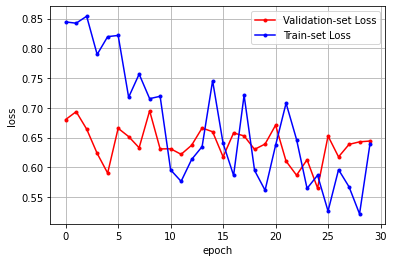

In [14]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))


plt.plot(x_len, y_vloss, marker='.', c='red', label="Validation-set Loss")
plt.plot(x_len, y_loss, marker='.', c='blue', label="Train-set Loss")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

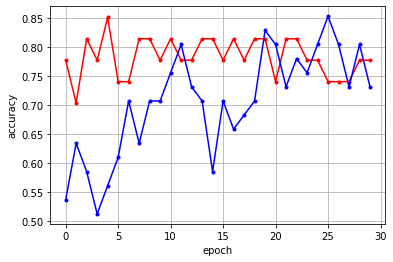

In [15]:
y_vacc = history.history['val_accuracy']
y_acc = history.history['accuracy']

x_len = np.arange(len(y_acc))

plt.plot(x_len, y_vacc, marker='.', c='red')
plt.plot(x_len, y_acc, marker='.', c='blue')

plt.grid()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [17]:
# 
img = load_img('../home/examples/1.jpg',target_size = (224,224))
img = img_to_array(img)
img = np.expand_dims(img,axis=0)
preds = model.predict(img)

print(preds)

[[0.76207983 0.38135612]]


In [18]:

img = load_img('../home/examples/card3.jpg',target_size = (224,224))
img = img_to_array(img)
img = np.expand_dims(img,axis=0)
preds = model.predict(img)

print(preds)

[[0.2907605 0.8935865]]


In [19]:

img = load_img('../home/examples/true.jpg',target_size = (224,224))
img = img_to_array(img)
img = np.expand_dims(img,axis=0)
preds = model.predict(img)

print(preds)

[[0.76207983 0.38135612]]
